### References:
* https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/
* https://www.analyticsvidhya.com/blog/2015/12/complete-tutorial-time-series-modeling/

### TODO:
* Understand the Augmented Dickey-Fuller unit root test for stationarity of the time series
> If $x(t) = \rho x(t-1) + Er(t)$ with $\rho < 1$, $x(t)$ is pushed back to zero and the series is stationary; if $\rho=1$, the series drifts away and is non-stationary. So, this test essentially consists of trying an auto-regression for $y(t) = x(t) - x(t-1) = (\rho-1) x(t-1) + Er(t)$ and testing the null hypothesis $\gamma = \rho - 1 = 0$.
* Confirm if ARIMA is really "just" a linear regression over $x[t-i]$, $error[t-i]$ and how the differences actually enter into the equation
> Regarding **differencing**: whenever differencing is used to stationarize a time series, the ARIMA model's parameter $d$ is the "differencing order" used.  
> **MA model**: linear regression of $x(t)$ as a function of a white noise process $error(t-i)$, $i=1,2,...,q$  
> **AR model**: linear regression of $x(t)$ as a function of $x(t-i)$, $i=1,2,...p$
* Understand how autocorrelation and partial autocorrelation plots are enough to find optimal values for $p$ and $q$ of an ARIMA model
> **autocorrelation**: by design, MA models have no autocorrelation for lags $\Delta t > q$; therefore, a cut-off in autocorrelation may be related to a good choice of $q$  
> **partial autocorrelation**: by design, the autocorrelation of AR models is fully explained using only lags $\Delta t \leq p$; therefore, a cut-off in partial autocorrelation may be related to a good choice of $p$
* Review this notebook in light of what I learn
* Study more sophisticated methods to make a non-stationary series stationary
* Calculate the autocorrelations of processes described by MA and AR models; later, consider a ARMA process

In [1]:
%load_ext autotime

In [2]:
import numpy as np
import pandas as pd
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

sns.set_context('talk')
sns.set_style('darkgrid')
sns.set_palette('pastel')

/home/felipe/.miniconda3/envs/ml/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


time: 12.3 s


In [3]:
date_parser = lambda dates: pd.datetime.strptime(dates, '%Y-%m')
passengers = pd.read_csv('../data/raw/AirPassengers.csv', index_col='Month',
                         parse_dates=['Month'], date_parser=date_parser)['#Passengers']\
               .sort_index()

time: 268 ms


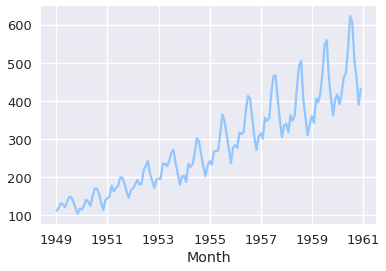

time: 919 ms


In [4]:
passengers.plot()

ADF test results:
adf                        0.815369
p-value                    0.991880
#lags                     13.000000
#obs                     130.000000
critical values (1%)      -3.481682
critical values (5%)      -2.884042
critical values (10%)     -2.578770
dtype: float64


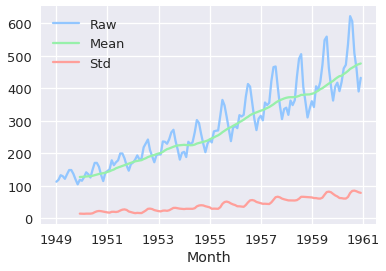

time: 537 ms


In [5]:
def test_stationarity(timeseries, window=12):
    rolling_mean = timeseries.rolling(window).mean()
    rolling_std = timeseries.rolling(window).std()
    fig, ax = plt.subplots()
    timeseries.plot(ax=ax, label='Raw')
    rolling_mean.plot(ax=ax, label='Mean')
    rolling_std.plot(ax=ax, label='Std')
    plt.legend(loc='best')
    *adf_test, critical_values, icbest = adfuller(timeseries)
    print('ADF test results:')
    print(pd.Series(data=list(adf_test) + list(critical_values.values()),
                    index=['adf', 'p-value', '#lags', '#obs'] +\
                          ['critical values ({})'.format(key) for key in critical_values.keys()]))
    
    
test_stationarity(passengers)

# Removing stationarity

### Log and rolling average

ADF test results:
adf                       -3.194202
p-value                    0.020323
#lags                     13.000000
#obs                     119.000000
critical values (1%)      -3.486535
critical values (5%)      -2.886151
critical values (10%)     -2.579896
dtype: float64


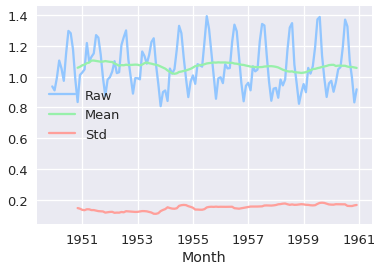

time: 270 ms


In [6]:
def remove_stationarity_v1(ts, window=12):
    ts_log = np.log(ts)
    rolling_log_mean = ts_log.rolling(window).mean()
    return np.exp(ts_log - rolling_log_mean)

passengers_v1 = remove_stationarity_v1(passengers)
test_stationarity(passengers_v1.dropna())

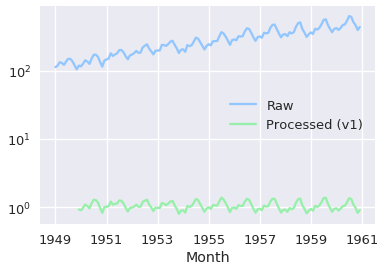

time: 546 ms


In [7]:
ax = passengers.plot(label='Raw', logy=True)
passengers_v1.plot(ax=ax, label='Processed (v1)')
plt.legend(loc='best')

### Log and weighted rolling average

ADF test results:
adf                       -3.577870
p-value                    0.006198
#lags                     13.000000
#obs                     130.000000
critical values (1%)      -3.481682
critical values (5%)      -2.884042
critical values (10%)     -2.578770
dtype: float64


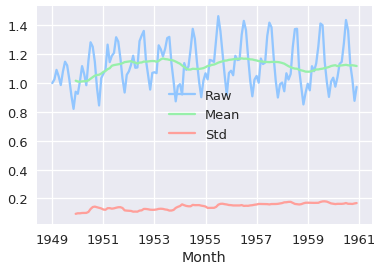

time: 201 ms


In [8]:
def remove_stationarity_v2(ts, halflife=12):
    ts_log = np.log(ts)
    rolling_weighted_log_mean = ts_log.ewm(halflife).mean()
    return np.exp(ts_log - rolling_weighted_log_mean)

passengers_v2 = remove_stationarity_v2(passengers)
test_stationarity(passengers_v2.dropna())

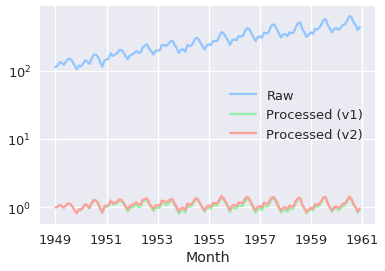

time: 377 ms


In [9]:
ax = passengers.plot(label='Raw', logy=True)
passengers_v1.plot(ax=ax, label='Processed (v1)')
passengers_v2.plot(ax=ax, label='Processed (v2)')
plt.legend(loc='best')

### Differencing

ADF test results:
adf                       -2.926109
p-value                    0.042395
#lags                     14.000000
#obs                     128.000000
critical values (1%)      -3.482501
critical values (5%)      -2.884398
critical values (10%)     -2.578960
dtype: float64


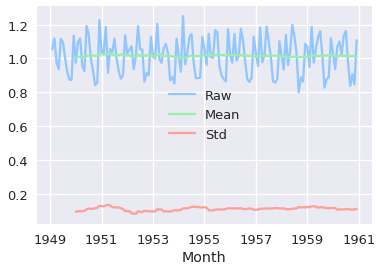

time: 228 ms


In [10]:
def remove_trend_and_seasonality_v1(ts):
    ts_log = np.log(ts)
    return np.exp(ts_log - ts_log.shift())

passengers_v3 = remove_trend_and_seasonality_v1(passengers)
test_stationarity(passengers_v3.dropna())

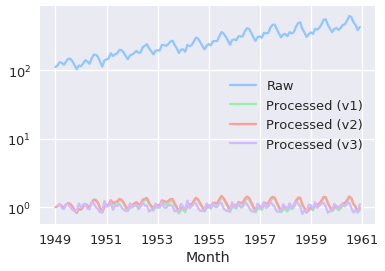

time: 392 ms


In [11]:
ax = passengers.plot(label='Raw', logy=True)
passengers_v1.plot(ax=ax, label='Processed (v1)')
passengers_v2.plot(ax=ax, label='Processed (v2)')
passengers_v3.plot(ax=ax, label='Processed (v3)')
plt.legend(loc='best')

### Decomposition

ADF test results:
adf                     -6.394855e+00
p-value                  2.062834e-08
#lags                    9.000000e+00
#obs                     1.220000e+02
critical values (1%)    -3.485122e+00
critical values (5%)    -2.885538e+00
critical values (10%)   -2.579569e+00
dtype: float64


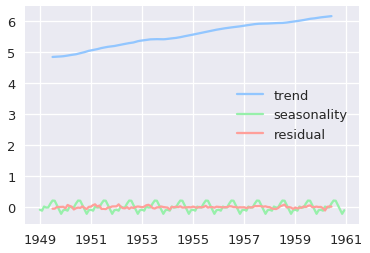

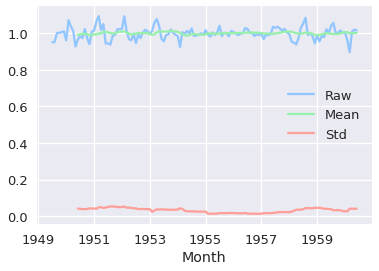

time: 344 ms


In [13]:
def remove_trend_by_decomposing(ts, take_log=True):
    ts2 = np.log(ts) if take_log else ts
    decomposition = seasonal_decompose(ts2)
    fig, ax = plt.subplots()
    ax.plot(decomposition.trend, label='trend')
    ax.plot(decomposition.seasonal, label='seasonality')
    ax.plot(decomposition.resid, label='residual')
    plt.legend(loc='best')
    return np.exp(decomposition.resid) if take_log else decomposition.resid

passengers_v4 = remove_trend_by_decomposing(passengers)
test_stationarity(passengers_v4.dropna())

ADF test results:
adf                       -5.298428
p-value                    0.000006
#lags                     13.000000
#obs                     118.000000
critical values (1%)      -3.487022
critical values (5%)      -2.886363
critical values (10%)     -2.580009
dtype: float64


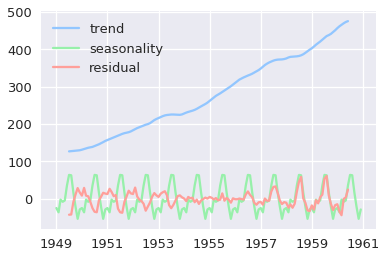

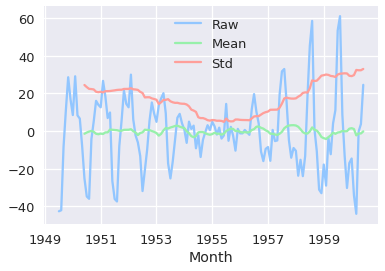

time: 439 ms


In [14]:
passengers_v5 = remove_trend_by_decomposing(passengers, take_log=False)
test_stationarity(passengers_v5.dropna())

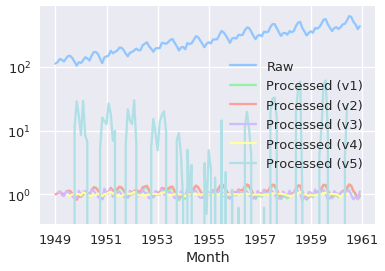

time: 431 ms


In [15]:
ax = passengers.plot(label='Raw', logy=True)
passengers_v1.plot(ax=ax, label='Processed (v1)')
passengers_v2.plot(ax=ax, label='Processed (v2)')
passengers_v3.plot(ax=ax, label='Processed (v3)')
passengers_v4.plot(ax=ax, label='Processed (v4)')
passengers_v5.plot(ax=ax, label='Processed (v5)')
plt.legend(loc='best')

# Forecasting

In [36]:
time_features = np.log(passengers_v3.dropna())

time: 3.08 ms


In [37]:
lag_acf = acf(time_features, nlags=20)
lag_pacf = pacf(time_features, nlags=20, method='ols')

time: 19.4 ms


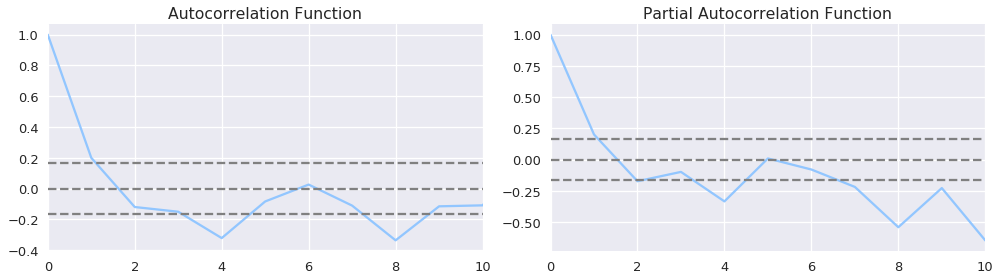

time: 267 ms


In [38]:
plt.figure(figsize=(14, 4))
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(time_features)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(time_features)), linestyle='--', color='gray')
plt.title('Autocorrelation Function')
plt.xlim(0, 10)
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(time_features)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(time_features)), linestyle='--', color='gray')
plt.title('Partial Autocorrelation Function')
plt.xlim(0, 10)
plt.tight_layout()

In [32]:
from statsmodels.tsa.arima_model import ARIMA

time: 1.49 ms


### AR model

/home/felipe/.miniconda3/envs/ml/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/home/felipe/.miniconda3/envs/ml/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
/home/felipe/.miniconda3/envs/ml/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


Text(0.5,1,'RSS: 1.5023 (d=0, diff before fit)')

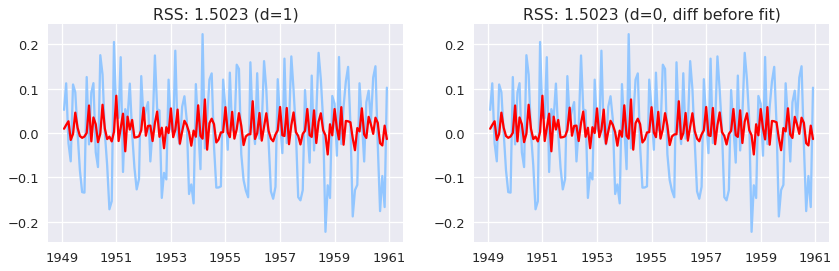

time: 471 ms


In [45]:
plt.figure(figsize=(14, 4))

model = ARIMA(np.log(passengers).dropna(), order=(2, 1, 0))
results_AR = model.fit()
plt.subplot(121)
plt.plot(time_features)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f (d=1)'% sum((results_AR.fittedvalues - time_features)**2))

time_features = np.log(passengers_v3).dropna()
model = ARIMA(time_features, order=(2, 0, 0))
results_AR = model.fit()
plt.subplot(122)
plt.plot(time_features)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f (d=0, diff before fit)'% sum((results_AR.fittedvalues - time_features)**2))

### MA model

/home/felipe/.miniconda3/envs/ml/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/home/felipe/.miniconda3/envs/ml/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
/home/felipe/.miniconda3/envs/ml/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


Text(0.5,1,'RSS: 1.4721 (d=0, diff before fit)')

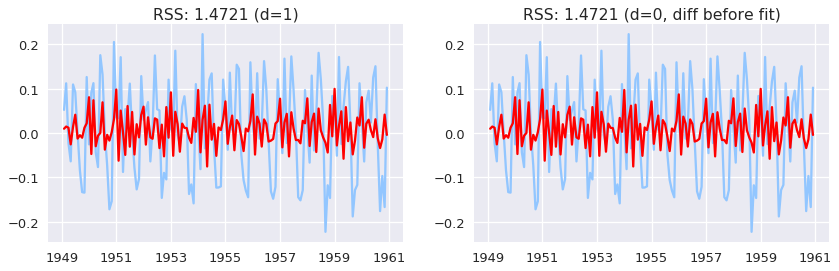

time: 442 ms


In [48]:
plt.figure(figsize=(14, 4))

model = ARIMA(np.log(passengers).dropna(), order=(0, 1, 2))
results_MA = model.fit()
plt.subplot(121)
plt.plot(time_features)
plt.plot(results_MA.fittedvalues, color='red')
plt.title('RSS: %.4f (d=1)'% sum((results_MA.fittedvalues - time_features)**2))

time_features = np.log(passengers_v3).dropna()
model = ARIMA(time_features, order=(0, 0, 2))
results_MA = model.fit()
plt.subplot(122)
plt.plot(time_features)
plt.plot(results_MA.fittedvalues, color='red')
plt.title('RSS: %.4f (d=0, diff before fit)'% sum((results_MA.fittedvalues - time_features)**2))

### Combined model

/home/felipe/.miniconda3/envs/ml/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/home/felipe/.miniconda3/envs/ml/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
/home/felipe/.miniconda3/envs/ml/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


Text(0.5,1,'RSS: 1.0292 (d=0, diff before fit)')

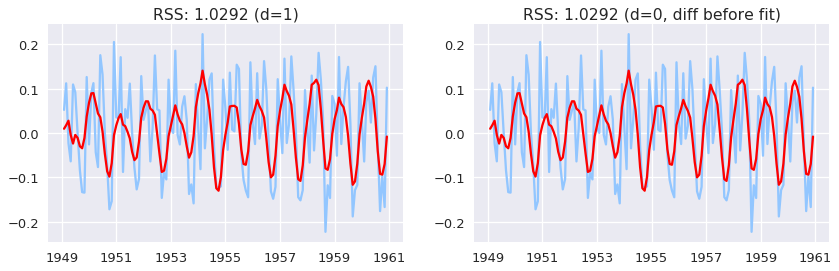

time: 1.11 s


In [49]:
plt.figure(figsize=(14, 4))

model = ARIMA(np.log(passengers).dropna(), order=(2, 1, 2))
results_ARIMA = model.fit()
plt.subplot(121)
plt.plot(time_features)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f (d=1)'% sum((results_ARIMA.fittedvalues - time_features)**2))

time_features = np.log(passengers_v3).dropna()
model = ARIMA(time_features, order=(2, 0, 2))
results_ARIMA = model.fit()
plt.subplot(122)
plt.plot(time_features)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f (d=0, diff before fit)'% sum((results_ARIMA.fittedvalues - time_features)**2))

In [57]:
# This step inverts the "diff" operation - similar to invert a derivative upon integration
pred_ARIMA_diff_cumsum = results_ARIMA.fittedvalues.cumsum()
# Because "diff" turns the first value to NaN, this step is needed to sum 
# the very first value of the time series, not taken into account by cumsum()
pred_ARIMA_log = pred_ARIMA_diff_cumsum + np.log(passengers.iat[0])
pred_ARIMA = np.exp(pred_ARIMA_log.fillna(0))

time: 7.32 ms


Text(0.5,1,'RMSE: 90.1047')

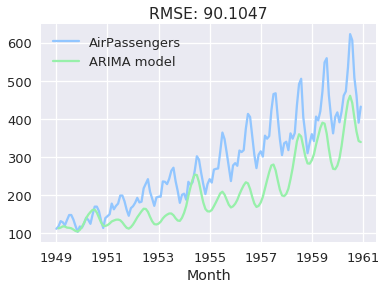

time: 194 ms


In [81]:
passengers.plot(label='AirPassengers')
pred_ARIMA.plot(label='ARIMA model')
plt.legend(loc='best')
rmse = np.sqrt(((pred_ARIMA - passengers)**2).sum() / len(passengers))
plt.title('RMSE: %.4f'% rmse)